In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sentiment-analysis-for-mental-health/Combined Data.csv


In [5]:
!pip install transformers torch pandas scikit-learn seaborn matplotlib tqdm

In [6]:
!pip install transformers==4.28.1


In [7]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import XLNetTokenizer, XLNetForSequenceClassification, AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

2025-06-20 07:34:41.774518: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750404881.797250     114 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750404881.804312     114 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [19]:
df = pd.read_csv('/kaggle/input/sentiment-analysis-for-mental-health/Combined Data.csv')
df = df.drop(columns=[col for col in df.columns if 'Unnamed' in col], errors='ignore')

In [12]:
# Show dataset summary
print("Dataset preview:")
print(df.head())
print("\nClass distribution:")
print(df['status'].value_counts())

Dataset preview:
   Unnamed: 0                                          statement   status
0           0                                         oh my gosh  Anxiety
1           1  trouble sleeping, confused mind, restless hear...  Anxiety
2           2  All wrong, back off dear, forward doubt. Stay ...  Anxiety
3           3  I've shifted my focus to something else but I'...  Anxiety
4           4  I'm restless and restless, it's been a month n...  Anxiety

Class distribution:
status
Normal                  16343
Depression              15404
Suicidal                10652
Anxiety                  3841
Bipolar                  2777
Stress                   2587
Personality disorder     1077
Name: count, dtype: int64


In [20]:
df = df.dropna(subset=['statement', 'status'])

In [21]:
#  Label encode
label_map = {
    'Normal': 0, 'Depression': 1, 'Suicidal': 2,
    'Anxiety': 3, 'Stress': 4, 'Bipolar': 5, 'Personality disorder': 6
}
df = df[df['status'].isin(label_map)]  # ensure valid
df['label'] = df['status'].map(label_map)

In [22]:
# Train‑Test split
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['statement'], df['label'], test_size=0.2,
    stratify=df['label'], random_state=42
)

In [23]:
# Tokenization
tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased')
train_enc = tokenizer(list(train_texts), padding=True, truncation=True, max_length=128)
val_enc = tokenizer(list(val_texts), padding=True, truncation=True, max_length=128)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


spiece.model:   0%|          | 0.00/798k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/760 [00:00<?, ?B/s]

In [26]:
# Dataset Class
class MHData(Dataset):
    def __init__(self, enc, labels):
        self.enc = enc
        self.labels = labels
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        return {
            'input_ids': torch.tensor(self.enc['input_ids'][idx]),
            'attention_mask': torch.tensor(self.enc['attention_mask'][idx]),
            'labels': torch.tensor(self.labels[idx])
        }

train_ds = MHData(train_enc, list(train_labels))
val_ds = MHData(val_enc, list(val_labels))

In [27]:
# 7️ Model and DataLoader
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = XLNetForSequenceClassification.from_pretrained('xlnet-base-cased', num_labels=7)
model.to(device)

train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=16)

optimizer = AdamW(model.parameters(), lr=2e-5)

pytorch_model.bin:   0%|          | 0.00/467M [00:00<?, ?B/s]

Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForSequenceClassification: ['lm_loss.bias', 'lm_loss.weight']
- This IS expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['sequence_summary.summary.weight', 'sequence_summary.summary.bias', 'logits_proj.bias', 'logits_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions a

In [28]:
#  Training
epochs = 3
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
        optimizer.zero_grad()
        out = model(
            input_ids=batch['input_ids'].to(device),
            attention_mask=batch['attention_mask'].to(device),
            labels=batch['labels'].to(device)
        )
        loss = out.loss
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1} avg loss: {total_loss/len(train_loader):.4f}")

Epoch 1: 100%|██████████| 2634/2634 [10:51<00:00,  4.04it/s]


Epoch 1 avg loss: 0.5948


Epoch 2: 100%|██████████| 2634/2634 [10:49<00:00,  4.05it/s]


Epoch 2 avg loss: 0.4024


Epoch 3: 100%|██████████| 2634/2634 [10:50<00:00,  4.05it/s]

Epoch 3 avg loss: 0.3173


Accuracy: 0.8257568567903578
                      precision    recall  f1-score   support

              Normal       0.98      0.93      0.95      3269
          Depression       0.83      0.67      0.74      3081
            Suicidal       0.65      0.89      0.75      2131
             Anxiety       0.90      0.89      0.89       768
              Stress       0.80      0.73      0.76       517
             Bipolar       0.88      0.87      0.87       556
Personality disorder       0.71      0.75      0.73       215

            accuracy                           0.83     10537
           macro avg       0.82      0.82      0.81     10537
        weighted avg       0.84      0.83      0.83     10537



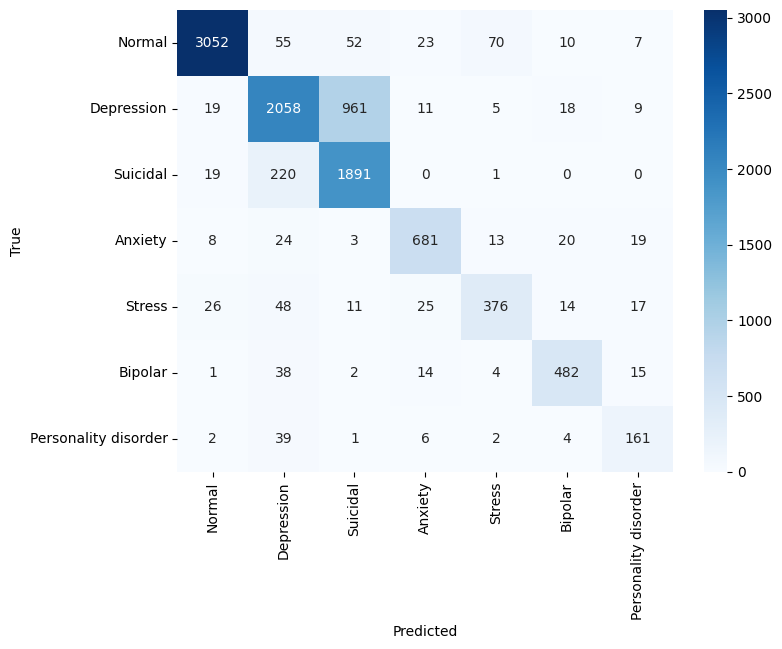

In [29]:
# Evaluation
model.eval()
preds, trues = [], []
with torch.no_grad():
    for batch in val_loader:
        out = model(
            input_ids=batch['input_ids'].to(device),
            attention_mask=batch['attention_mask'].to(device)
        )
        pred = torch.argmax(out.logits, dim=1).cpu().numpy()
        preds.extend(pred)
        trues.extend(batch['labels'].cpu().numpy())

print("Accuracy:", accuracy_score(trues, preds))
print(classification_report(trues, preds, target_names=label_map.keys()))

cm = confusion_matrix(trues, preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_map.keys(), yticklabels=label_map.keys())
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()